# Fetching restaurant data from Wake County

## Imports

In [ ]:
#!pip install phonenumbers
#!pip install folium
#!pip install geopandas

In [1]:
# import pandas, numpy, matplotlib, seaborn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing the requests library
import requests

import urllib.request
from pathlib import Path
import json
import os

# import phonenumbers package
import phonenumbers

from pandas_profiling import ProfileReport

import folium
from folium import plugins
import geopandas as gpd
import plotly.express as px
%matplotlib inline

## Resources
 1. [Restaurants in Wake County Data Info](https://www.arcgis.com/home/item.html?id=124c2187da8c41c59bde04fa67eb2872)
 2. [Wake County Open Data](https://data-wake.opendata.arcgis.com/search?tags=restaurants)
 3. [Food Inspection Violations Data Info](https://data.wakegov.com/datasets/Wake::food-inspection-violations/about)
 4. [Wake County Yelp Initiative](https://ash.harvard.edu/news/wake-county-yelp-initiative)

## Fetch Restaurants from wakegov

In [2]:
def getRestaurantsDf(forceFetch=False):
        path = Path()
        key = 'restaurants.csv'
        filename = path/key
        
        # If the file does already exist in the directory, download it
        if os.path.exists(filename) and not forceFetch:
            print('Using pre-fetched restaurants data...')
            df = pd.read_csv(key)
            print('restaurants df shape:', df.shape)
            return df
    
        # Source restaurants data in wake county from wakegov
        # base_url = "https://maps.wakegov.com/arcgis/rest/services/Inspections/RestaurantInspectionsOpenData/MapServer/0/query?f=json&where=(FACILITYTYPE%20IN%20('Restaurant'))&outFields=*"
        else:
            print('Fetching restaurants data...')
            val = 'https://opendata.arcgis.com/datasets/124c2187da8c41c59bde04fa67eb2872_0.geojson'

            # Sending get request and saving the response as response object
            # extracting data in json 
            r = requests.get(url = val)
            rows = []
            data = r.json()['features']
            for d in data:
                rows.append(d['properties'])
            df = pd.DataFrame(rows)
            print('restaurants df shape:', df.shape)
            df.to_csv(key, index=False)
            print('Done')
            return df

restaurants_df_raw = getRestaurantsDf(forceFetch=False)
display(restaurants_df_raw.head())

Using pre-fetched restaurants data...
restaurants df shape: (3635, 15)


,OBJECTID,HSISID,NAME,ADDRESS1,ADDRESS2,CITY,STATE,POSTALCODE,PHONENUMBER,RESTAURANTOPENDATE,FACILITYTYPE,PERMITID,X,Y,GEOCODESTATUS
0,1924822,4092016155,DAILY PLANET CAFE,11 W JONES ST,STE 1509,RALEIGH,NC,27601,(919) 707-8060,2012-04-12T04:00:00Z,Restaurant,2,-78.639431,35.782205,M
1,1924823,4092016161,HIBACHI 88,3416 POOLE RD,NaN,RALEIGH,NC,27610,(919) 231-1688,2012-04-18T04:00:00Z,Restaurant,4,-78.579533,35.767246,M
2,1924824,4092017180,BOND BROTHERS BEER COMPANY,202 E CEDAR ST,NaN,CARY,NC,27511,(919) 459-2670,2016-03-11T05:00:00Z,Restaurant,5,-78.778021,35.787986,M
3,1924825,4092018352,Prime Barbeque,403 KNIGHTDALE STATION RUN,NaN,KNIGHTDALE,NC,27545,(919) 373-8076,2020-04-22T04:00:00Z,Restaurant,6,-78.473566,35.797225,M
4,1924826,4092030440,Taco Veloz (WCID #736),1312 N ARENDELL AVE,NaN,ZEBULON,NC,27597-8732,(914) 497-2580,2019-08-26T04:00:00Z,Mobile Food Units,10,-78.323927,35.838678,M


## Preprocessing

In [3]:
# normalize to E164 format
def normalize_phone(phone):
    try:
        phone = phone.split("ext")[0].strip()
        z = phonenumbers.parse(phone, 'US')
        retVal = phonenumbers.format_number(z, phonenumbers.PhoneNumberFormat.E164)
        return retVal
    except:
        return phone

In [4]:
def preprocess_restaurants(df):
    # Drop duplicates in place
    df.drop_duplicates(inplace=True)
    
    # Drop columns w/ > 25% missing values
    missing_value_columns = df.columns[df.isna().mean() >= 0.25]
    print('Dropping columns with more than 25% missing values:', missing_value_columns)
    df = df.drop(missing_value_columns, axis=1)
    
    # get only restaurants (filtering by facilitytype)
    df = df[df['FACILITYTYPE'] == 'Restaurant']
    
    # Drop single value column
    df = df.drop('FACILITYTYPE', axis=1)

    # Drop irrelevant columns
    df = df.drop('STATE', axis=1) 
    
    # Convert rest open date
    df['RESTAURANTOPENDATE'] = pd.to_datetime(df['RESTAURANTOPENDATE']).dt.date
    
    # Normalize phone numbers
    df['PHONENUMBER'] = df['PHONENUMBER'].apply(lambda x: normalize_phone(x)) 
    # fix from float to normalized string numbers
    df['PHONENUMBER'] = df['PHONENUMBER'].apply(lambda a: str(a).split('.')[0])
    df['PHONENUMBER'] = df['PHONENUMBER'].astype(str)

    return df

## Call preprocess & validate 

In [5]:
# Validate shape & data
# https://data-wake.opendata.arcgis.com/datasets/Wake::restaurants-in-wake-county/explore?filters=eyJGQUNJTElUWVRZUEUiOlsiUmVzdGF1cmFudCJdfQ%3D%3D&location=35.794181%2C-78.605600%2C3.98&showTable=true

print('\nDisplay Raw Data Info ------------------------------\n')
display({column: len(restaurants_df_raw[column].unique()) for column in restaurants_df_raw.columns})

# Preprocess
print('\nPreprocessing --------------------------------------\n')
restaurants_df = preprocess_restaurants(restaurants_df_raw.copy())
print(restaurants_df.info())


Display Raw Data Info ------------------------------



{'OBJECTID': 3635,
 'HSISID': 3635,
 'NAME': 3501,
 'ADDRESS1': 3162,
 'ADDRESS2': 297,
 'CITY': 45,
 'STATE': 1,
 'POSTALCODE': 563,
 'PHONENUMBER': 3120,
 'RESTAURANTOPENDATE': 2251,
 'FACILITYTYPE': 10,
 'PERMITID': 3635,
 'X': 2153,
 'Y': 2153,
 'GEOCODESTATUS': 3}


Preprocessing --------------------------------------

Dropping columns with more than 25% missing values: Index(['ADDRESS2'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2380 entries, 0 to 3634
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OBJECTID            2380 non-null   int64  
 1   HSISID              2380 non-null   int64  
 2   NAME                2380 non-null   object 
 3   ADDRESS1            2380 non-null   object 
 4   CITY                2380 non-null   object 
 5   POSTALCODE          2380 non-null   object 
 6   PHONENUMBER         2380 non-null   object 
 7   RESTAURANTOPENDATE  2380 non-null   object 
 8   PERMITID            2380 non-null   int64  
 9   X                   2380 non-null   float64
 10  Y                   2380 non-null   float64
 11  GEOCODESTATUS       2380 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 241.7+ KB


In [6]:
restaurants_df['POSTALCODE'].nunique()

356

In [7]:
restaurants_df['PHONENUMBER'].nunique()

2255

In [8]:
display(restaurants_df.head())

,OBJECTID,HSISID,NAME,ADDRESS1,CITY,POSTALCODE,PHONENUMBER,RESTAURANTOPENDATE,PERMITID,X,Y,GEOCODESTATUS
0,1924822,4092016155,DAILY PLANET CAFE,11 W JONES ST,RALEIGH,27601,+19197078060,2012-04-12,2,-78.639431,35.782205,M
1,1924823,4092016161,HIBACHI 88,3416 POOLE RD,RALEIGH,27610,+19192311688,2012-04-18,4,-78.579533,35.767246,M
2,1924824,4092017180,BOND BROTHERS BEER COMPANY,202 E CEDAR ST,CARY,27511,+19194592670,2016-03-11,5,-78.778021,35.787986,M
3,1924825,4092018352,Prime Barbeque,403 KNIGHTDALE STATION RUN,KNIGHTDALE,27545,+19193738076,2020-04-22,6,-78.473566,35.797225,M
6,1924828,4092017192,STARBUCKS #19453,185 GRAND HILL PL,HOLLY SPRINGS,27540,+19195573246,2016-04-05,16,-78.849481,35.662665,M


## Save preprocessed restaurants data in preprocessed_restaurants

In [9]:
restaurants_df.to_csv('preprocessed_restaurants.csv', index=False)

In [10]:
rests = pd.read_csv('preprocessed_restaurants.csv', dtype={'PHONENUMBER': str})
rests.head()

,OBJECTID,HSISID,NAME,ADDRESS1,CITY,POSTALCODE,PHONENUMBER,RESTAURANTOPENDATE,PERMITID,X,Y,GEOCODESTATUS
0,1924822,4092016155,DAILY PLANET CAFE,11 W JONES ST,RALEIGH,27601,+19197078060,2012-04-12,2,-78.639431,35.782205,M
1,1924823,4092016161,HIBACHI 88,3416 POOLE RD,RALEIGH,27610,+19192311688,2012-04-18,4,-78.579533,35.767246,M
2,1924824,4092017180,BOND BROTHERS BEER COMPANY,202 E CEDAR ST,CARY,27511,+19194592670,2016-03-11,5,-78.778021,35.787986,M
3,1924825,4092018352,Prime Barbeque,403 KNIGHTDALE STATION RUN,KNIGHTDALE,27545,+19193738076,2020-04-22,6,-78.473566,35.797225,M
4,1924828,4092017192,STARBUCKS #19453,185 GRAND HILL PL,HOLLY SPRINGS,27540,+19195573246,2016-04-05,16,-78.849481,35.662665,M


# Profile Report

In [ ]:
profile = ProfileReport(restaurants_df, title="Pandas Profiling Report", explorative=True)
profile

,centroid_lat,centroid_lon,car_hours,peak_hour
0,45.471549,-73.588684,1772.750000,2
1,45.543865,-73.562456,986.333333,23
2,45.487640,-73.642767,354.750000,20
3,45.522870,-73.595677,560.166667,23
4,45.453971,-73.738946,2836.666667,19


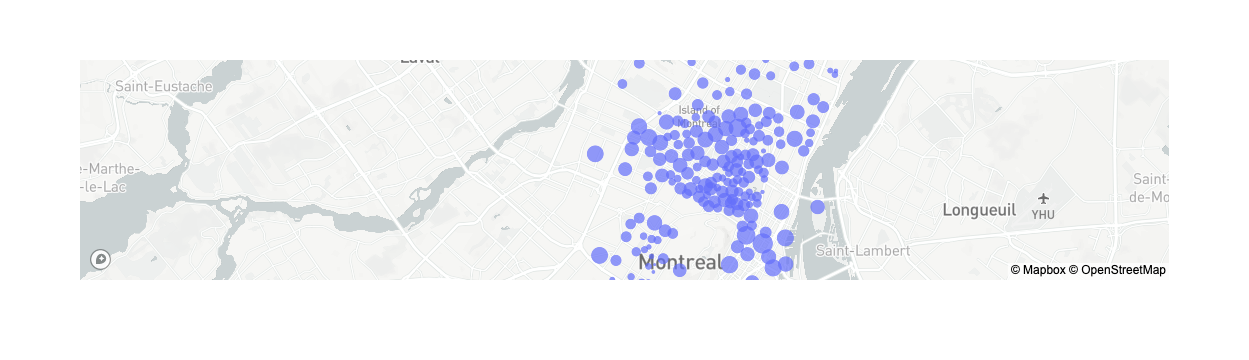

In [21]:
import plotly.express as px
mbtoken = 'pk.eyJ1IjoiaGVhcnNjaCIsImEiOiJja3Z6eGdzbGgwc2lmMm5ycDI2ZHE2bjhwIn0.H7rY4NZjvHX3ihaZwCFaXw'
px.set_mapbox_access_token(mbtoken)
df = px.data.carshare()
display(df.head())
fig = px.scatter_mapbox(df, lat="centroid_lat", lon="centroid_lon", size="car_hours",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()